In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight # הוספנו את פונקציית המשקולות
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar




In [3]:
# ==========================================
# 1. System Settings and Parameters
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"🚀 Using device: {device}")

SEQ_LENGTH = 5  # Sequence length: The model will see 2.5 minutes at a time
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# ==========================================
# 2. Data Loading (using the raw Train file)
# ==========================================
print("📂 Loading data...")
# Make sure this file exists in your directory
data = np.load('train_smote_final.npz') 
X_full = data['x'] # Expected structure: (Epochs, Time, Channels)
y_full = data['y']

# Split into train and validation (stratified split to preserve class ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ==========================================
# 3. Dataset Class (Sequence-based)
# ==========================================
class SleepSequenceDataset(Dataset):
    def __init__(self, x_data, y_data, seq_length=5):
        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).long()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.y) - self.seq_length + 1

    def __getitem__(self, idx):
        # Extract a sequence of epochs
        x_seq = self.x[idx : idx + self.seq_length] 
        # The label is from the last epoch in the sequence
        y_label = self.y[idx + self.seq_length - 1]
        return x_seq, y_label

train_dataset = SleepSequenceDataset(X_train, y_train, seq_length=SEQ_LENGTH)
val_dataset = SleepSequenceDataset(X_val, y_val, seq_length=SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Ready! Sequences: {len(train_dataset)}")

# ==========================================
# 4. Model Architecture (SleepNet Seq)
# ==========================================
class SleepNetSeq(nn.Module):
    def __init__(self, num_classes=5):
        super(SleepNetSeq, self).__init__()
        
        # Branch 1: The two EEG channels
        self.eeg_branch = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=50, stride=5), # 2 input channels
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # Branch 2: The single EOG channel
        self.eog_branch = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=50, stride=5), # 1 input channel
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # Combine features after splitting
        self.common_conv = nn.Sequential(
            nn.Conv1d(32 + 16, 64, kernel_size=8, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        
        # Bidirectional GRU for temporal sequence processing
        self.gru = nn.GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, Seq, Time, Chans)
        bs, seq, ts, ch = x.size()
        
        # Flatten Batch and Sequence for the CNN
        x = x.view(bs * seq, ts, ch).transpose(1, 2) # (BS*Seq, Chans, Time)
        
        # Split channels: assuming 0,1 are EEG and 2 is EOG
        eeg_input = x[:, 0:2, :] # Channels 0 and 1
        eog_input = x[:, 2:3, :] # Channel 2
        
        # Pass through the separate branches
        eeg_feat = self.eeg_branch(eeg_input)
        eog_feat = self.eog_branch(eog_input)
        
        # Concatenation of features
        combined_feat = torch.cat((eeg_feat, eog_feat), dim=1)
        
        # Shared processing
        x = self.common_conv(combined_feat)
        
        # Average over time (Global Average Pooling)
        x = torch.mean(x, dim=2) 
        
        # Reshape back to sequence structure (BS, Seq, Features)
        x = x.view(bs, seq, 64) 
        
        # GRU
        gru_out, _ = self.gru(x)
        
        # Take the last epoch in the sequence for classification
        out = self.fc(gru_out[:, -1, :])
        return out

# ==========================================
# 5. Loss Definition and Weights
# ==========================================
model = SleepNetSeq().to(device)

# Calculate weights to balance N1
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

🚀 Using device: mps
📂 Loading data...
✅ Data Ready! Sequences: 221216


In [3]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ==========================================
# 6. Training Loop
# ==========================================
print("\n" + "="*30)
print("🏃 Starting Sequence Training...")
print("="*30)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Acc: {100.*correct/total:.2f}% | Val Acc: {100.*val_correct/val_total:.2f}%")

torch.save(model.state_dict(), 'model_smote.pth')
print("\n🎉 Training Complete!")


🏃 Starting Sequence Training...
Epoch [1/15] | Train Acc: 78.55% | Val Acc: 80.05%
Epoch [2/15] | Train Acc: 82.95% | Val Acc: 83.43%
Epoch [3/15] | Train Acc: 84.02% | Val Acc: 83.71%
Epoch [4/15] | Train Acc: 84.76% | Val Acc: 82.21%
Epoch [5/15] | Train Acc: 85.47% | Val Acc: 85.01%
Epoch [6/15] | Train Acc: 85.93% | Val Acc: 85.76%
Epoch [7/15] | Train Acc: 86.46% | Val Acc: 86.27%
Epoch [8/15] | Train Acc: 86.82% | Val Acc: 85.53%
Epoch [9/15] | Train Acc: 87.16% | Val Acc: 86.35%
Epoch [10/15] | Train Acc: 87.55% | Val Acc: 86.08%
Epoch [11/15] | Train Acc: 87.91% | Val Acc: 83.90%
Epoch [12/15] | Train Acc: 88.30% | Val Acc: 86.48%
Epoch [13/15] | Train Acc: 88.72% | Val Acc: 86.15%
Epoch [14/15] | Train Acc: 89.08% | Val Acc: 86.56%
Epoch [15/15] | Train Acc: 89.49% | Val Acc: 86.72%

🎉 Training Complete!


🚀 Analyzing model in Many-to-One mode...
✅ Fixed! Labels: 1943, Predictions: 1943

📈 --- Classification Report (Many-to-One) ---
              precision    recall  f1-score   support

        Wake       0.97      0.94      0.95       682
          N1       0.51      0.62      0.56       179
          N2       0.90      0.78      0.84       676
          N3       0.72      0.91      0.80       126
         REM       0.75      0.86      0.80       280

    accuracy                           0.84      1943
   macro avg       0.77      0.82      0.79      1943
weighted avg       0.86      0.84      0.84      1943



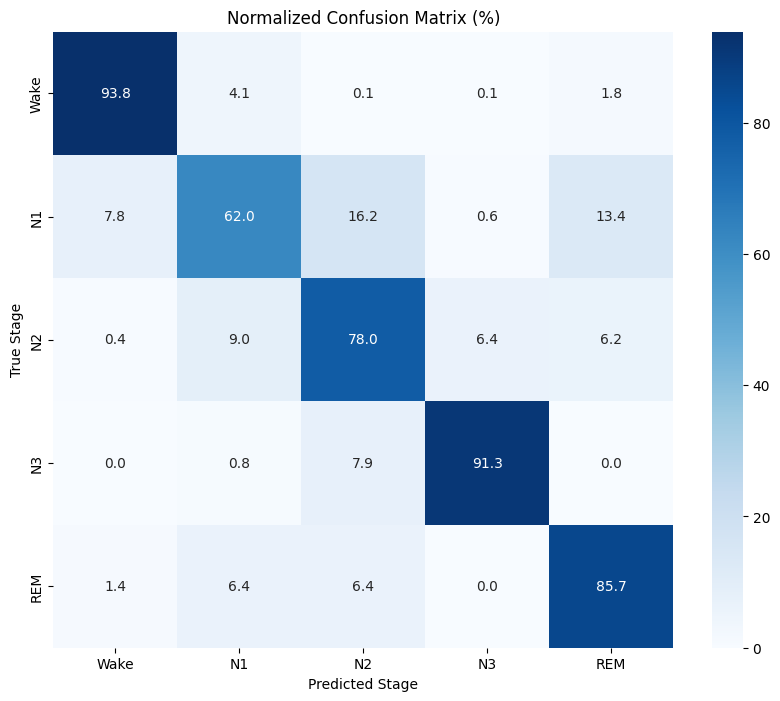

In [4]:
# --- Settings ---
SEQ_LEN = 20  # Must be identical to the sequence length used during training!
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available(): DEVICE = torch.device('mps')

# 1. Loading and shaping data into sequences
data = np.load('test_final.npz')
X_raw = data['x']  # (N, 3000, 3)
y_raw = data['y']  # (N,)

def create_sequences(X, y, seq_len):
    n_seq = len(X) // seq_len
    X_seq = X[:n_seq * seq_len].reshape(n_seq, seq_len, 3000, 3)
    y_seq = y[:n_seq * seq_len].reshape(n_seq, seq_len)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.long)

X_test_seq, y_test_seq = create_sequences(X_raw, y_raw, SEQ_LEN)
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=32)

# 2. Running the model
model.to(DEVICE)
model.eval()
all_preds = []
all_labels = []

print("🚀 Analyzing model in Many-to-One mode...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs) # Output shape: (Batch, 5)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        # Take only the last label from each sequence (index -1)
        # Original labels shape is (Batch, Seq_Len)
        last_label_in_seq = labels[:, -1] 
        all_labels.extend(last_label_in_seq.numpy())

print(f"✅ Fixed! Labels: {len(all_labels)}, Predictions: {len(all_preds)}")

# --- Results Report ---

stages = ['Wake', 'N1', 'N2', 'N3', 'REM']
unique_idx = np.unique(all_labels).astype(int)
target_names = [stages[i] for i in unique_idx]

print("\n📈 --- Classification Report (Many-to-One) ---")
print(classification_report(all_labels, all_preds, labels=unique_idx, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_idx)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(cm_perc, annot=True, fmt='.1f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Stage')
plt.ylabel('True Stage')
plt.show()

In [ ]:
# ==========================================
# 1. System Settings & Parameters
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"🚀 Using device: {device}")

SEQ_LENGTH = 5  # Sequence length: the model will see 2.5 minutes at a time
BATCH_SIZE = 64
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# ==========================================
# 2. Data Loading (Using the raw Train file)
# ==========================================
print("📂 Loading data...")
# Ensure this file exists in your directory
data = np.load('train_ros_final.npz') 
X_full = data['x'] # Expected structure: (Epochs, Time, Channels)
y_full = data['y']

# Train/Validation split (stratified to maintain class ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ==========================================
# 3. Dataset Class (Sequence-based)
# ==========================================
class SleepSequenceDataset(Dataset):
    def __init__(self, x_data, y_data, seq_length=5):
        self.x = torch.from_numpy(x_data).float()
        self.y = torch.from_numpy(y_data).long()
        self.seq_length = seq_length

    def __len__(self):
        return len(self.y) - self.seq_length + 1

    def __getitem__(self, idx):
        # Extracting a sequence of epochs
        x_seq = self.x[idx : idx + self.seq_length] 
        # The label corresponds to the last epoch in the sequence
        y_label = self.y[idx + self.seq_length - 1]
        return x_seq, y_label

train_dataset = SleepSequenceDataset(X_train, y_train, seq_length=SEQ_LENGTH)
val_dataset = SleepSequenceDataset(X_val, y_val, seq_length=SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Ready! Sequences: {len(train_dataset)}")

# ==========================================
# 4. Model Architecture (SleepNet Seq)
# ==========================================
class SleepNetSeq(nn.Module):
    def __init__(self, num_classes=5):
        super(SleepNetSeq, self).__init__()
        
        # Branch 1: The two EEG channels
        self.eeg_branch = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=50, stride=5), # 2 input channels
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # Branch 2: The single EOG channel
        self.eog_branch = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=50, stride=5), # 1 input channel
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(8)
        )
        
        # Feature combination after splitting
        self.common_conv = nn.Sequential(
            nn.Conv1d(32 + 16, 64, kernel_size=8, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        
        # Bidirectional GRU for temporal sequence processing
        self.gru = nn.GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (Batch, Seq, Time, Chans)
        bs, seq, ts, ch = x.size()
        
        # Flatten Batch and Sequence for the CNN
        x = x.view(bs * seq, ts, ch).transpose(1, 2) # (BS*Seq, Chans, Time)
        
        # Channel splitting: Assuming 0,1 are EEG and 2 is EOG
        eeg_input = x[:, 0:2, :] # Channels 0 and 1
        eog_input = x[:, 2:3, :] # Channel 2
        
        # Passing through the separate branches
        eeg_feat = self.eeg_branch(eeg_input)
        eog_feat = self.eog_branch(eog_input)
        
        # Concatenation of features
        combined_feat = torch.cat((eeg_feat, eog_feat), dim=1)
        
        # Joint processing
        x = self.common_conv(combined_feat)
        
        # Global Average Pooling over time
        x = torch.mean(x, dim=2) 
        
        # Reshape back to sequence structure (BS, Seq, Features)
        x = x.view(bs, seq, 64) 
        
        # GRU
        gru_out, _ = self.gru(x)
        
        # Take the last epoch in the sequence for classification
        out = self.fc(gru_out[:, -1, :])
        return out

# ==========================================
# 5. Loss Definition & Weights
# ==========================================
model = SleepNetSeq().to(device)

# Calculate weights to balance N1
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ==========================================
# 6. Training Loop
# ==========================================
print("\n" + "="*30)
print("🏃 Starting Sequence Training...")
print("="*30)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Acc: {100.*correct/total:.2f}% | Val Acc: {100.*val_correct/val_total:.2f}%")

torch.save(model.state_dict(), 'model_ros11.pth')
print("\n🎉 Training Complete!")

🚀 Using device: mps
📂 Loading data...
✅ Data Ready! Sequences: 221216

🏃 Starting Sequence Training...
Epoch [1/15] | Train Acc: 75.56% | Val Acc: 78.76%
Epoch [2/15] | Train Acc: 79.64% | Val Acc: 79.90%
Epoch [3/15] | Train Acc: 80.86% | Val Acc: 80.45%
Epoch [4/15] | Train Acc: 81.72% | Val Acc: 80.17%


🚀 Analyzing model in Many-to-One mode...
✅ Fixed! Labels: 1943, Predictions: 1943

📈 --- Classification Report (Many-to-One) ---
              precision    recall  f1-score   support

        Wake       0.98      0.90      0.94       682
          N1       0.45      0.65      0.53       179
          N2       0.90      0.80      0.85       676
          N3       0.71      0.94      0.81       126
         REM       0.83      0.84      0.83       280

    accuracy                           0.84      1943
   macro avg       0.77      0.83      0.79      1943
weighted avg       0.86      0.84      0.85      1943



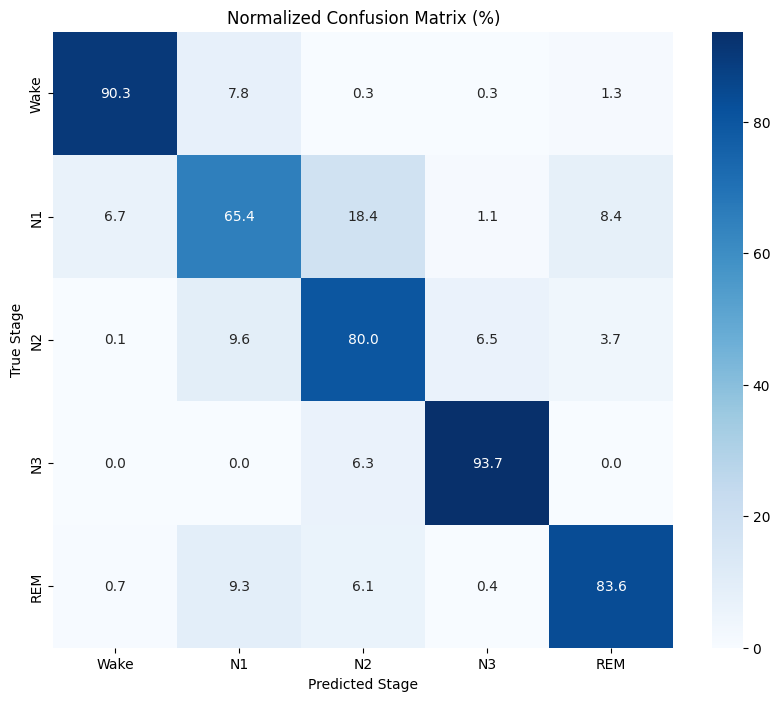

In [ ]:
# --- Settings ---
SEQ_LEN = 20  # Must be identical to the sequence length used during training!
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available(): DEVICE = torch.device('mps')

# 1. Loading and reshaping data into sequences
data = np.load('test_final.npz')
X_raw = data['x']  # Shape: (N, 3000, 3)
y_raw = data['y']  # Shape: (N,)

def create_sequences(X, y, seq_len):
    n_seq = len(X) // seq_len
    X_seq = X[:n_seq * seq_len].reshape(n_seq, seq_len, 3000, 3)
    y_seq = y[:n_seq * seq_len].reshape(n_seq, seq_len)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.long)

X_test_seq, y_test_seq = create_sequences(X_raw, y_raw, SEQ_LEN)

# Ensure SleepNetSeq is defined or imported before this
model = SleepNetSeq()
weights_path = 'model_ros.pth'  # Change to 'model_smote.pth' depending on which model you are evaluating
model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=32)

# 2. Model Evaluation
model.to(DEVICE)
model.eval()
all_preds = []
all_labels = []

print("🚀 Analyzing model in Many-to-One mode...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs) # Output shape: (Batch, 5)
        
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        
        # Taking only the last label from each sequence (index -1)
        # Original labels shape is (Batch, Seq_Len)
        last_label_in_seq = labels[:, -1] 
        all_labels.extend(last_label_in_seq.numpy())

print(f"✅ Fixed! Labels: {len(all_labels)}, Predictions: {len(all_preds)}")

stages = ['Wake', 'N1', 'N2', 'N3', 'REM']
unique_idx = np.unique(all_labels).astype(int)
target_names = [stages[i] for i in unique_idx]

print("\n📈 --- Classification Report (Many-to-One) ---")
print(classification_report(all_labels, all_preds, labels=unique_idx, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_idx)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_perc, annot=True, fmt='.1f', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Stage')
plt.ylabel('True Stage')
plt.show()

In [ ]:
# ==========================================
# Base Settings and Data Loading (To prevent NameError)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 5
BATCH_SIZE = 64

print("📂 Loading Test Data from file...")
test_data = np.load('test_final.npz')
X_test, y_test = test_data['x'], test_data['y']

# ==========================================
# 0. Creating the Test Loader 
# ==========================================
print("📦 Creating Test DataLoader...")
test_dataset = SleepSequenceDataset(X_test, y_test, seq_length=SEQ_LENGTH)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 1. Preparing Variables and Loading Models
# ==========================================
y_true = []
preds_smote = []
preds_ros = []

print("🔄 Loading models for comparison...")
m_smote = SleepNetSeq().to(device)
m_smote.load_state_dict(torch.load('model_smote.pth', map_location=device))
m_smote.eval()

m_ros = SleepNetSeq().to(device)
m_ros.load_state_dict(torch.load('model_ros.pth', map_location=device))
m_ros.eval()

# ==========================================
# 2. Generating Predictions
# ==========================================
print("🧠 Generating predictions on the Test Set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        
        # List of true labels
        y_true.extend(labels.cpu().numpy())
        
        # SMOTE model predictions
        out_smote = m_smote(inputs)
        _, p_smote = torch.max(out_smote, 1)
        preds_smote.extend(p_smote.cpu().numpy())
        
        # ROS model predictions
        out_ros = m_ros(inputs)
        _, p_ros = torch.max(out_ros, 1)
        preds_ros.extend(p_ros.cpu().numpy())

print("✅ Predictions complete. Running McNemar's Test...")

# ==========================================
# 3. McNemar's Test - Building the Table and Calculating
# ==========================================
both_correct = 0
smote_correct_ros_wrong = 0
ros_correct_smote_wrong = 0
both_wrong = 0

for t, p_s, p_r in zip(y_true, preds_smote, preds_ros):
    s_correct = (p_s == t)
    r_correct = (p_r == t)
    
    if s_correct and r_correct:
        both_correct += 1
    elif s_correct and not r_correct:
        smote_correct_ros_wrong += 1
    elif not s_correct and r_correct:
        ros_correct_smote_wrong += 1
    else:
        both_wrong += 1

table = [[both_correct, smote_correct_ros_wrong],
         [ros_correct_smote_wrong, both_wrong]]

print("\n📊 --- McNemar's Test Contingency Table ---")
print(f"Both models correct: {both_correct}")
print(f"Both models wrong: {both_wrong}")
print(f"SMOTE correct, ROS wrong: {smote_correct_ros_wrong}")
print(f"ROS correct, SMOTE wrong: {ros_correct_smote_wrong}")

# Calculating P-Value
from statsmodels.stats.contingency_tables import mcnemar # Just in case it wasn't imported earlier
result = mcnemar(table, exact=False, correction=True)

print(f"\n📈 McNemar's Test P-Value: {result.pvalue:.5f}")

if result.pvalue < 0.05:
    print("✅ Conclusion: The difference in predictive performance between the models is statistically significant!")
else:
    print("⚠️ Conclusion: No statistically significant difference between the models.")

📂 Loading Test Data from file...
📦 Creating Test DataLoader...
🔄 Loading models for comparison...
🧠 Generating predictions on the Test Set...
✅ Predictions complete. Running McNemar's Test...

📊 --- McNemar's Test Contingency Table ---
Both models correct: 29409
Both models wrong: 4635
SMOTE correct, ROS wrong: 2422
ROS correct, SMOTE wrong: 2390

📈 McNemar's Test P-Value: 0.65496
⚠️ Conclusion: No statistically significant difference between the models.


🔄 Loading model for evaluation: model_smote.pth
   ✅ Chunk 1/10: F1 = 0.8687
   ✅ Chunk 2/10: F1 = 0.8677
   ✅ Chunk 3/10: F1 = 0.8649
   ✅ Chunk 4/10: F1 = 0.8633
   ✅ Chunk 5/10: F1 = 0.8641
   ✅ Chunk 6/10: F1 = 0.8666
   ✅ Chunk 7/10: F1 = 0.8645
   ✅ Chunk 8/10: F1 = 0.8684
   ✅ Chunk 9/10: F1 = 0.8592
   ✅ Chunk 10/10: F1 = 0.8650
🔄 Loading model for evaluation: model_ros.pth
   ✅ Chunk 1/10: F1 = 0.7988
   ✅ Chunk 2/10: F1 = 0.8008
   ✅ Chunk 3/10: F1 = 0.8054
   ✅ Chunk 4/10: F1 = 0.8027
   ✅ Chunk 5/10: F1 = 0.7953
   ✅ Chunk 6/10: F1 = 0.7984
   ✅ Chunk 7/10: F1 = 0.8032
   ✅ Chunk 8/10: F1 = 0.7867
   ✅ Chunk 9/10: F1 = 0.7894
   ✅ Chunk 10/10: F1 = 0.7953

📊 Statistical Test Results
SMOTE (Mean F1): 0.8652
ROS (Mean F1):   0.7976
📊 P-Value (in favor of ROS): 1.00000

⚠️ Conclusion: No statistically significant difference.


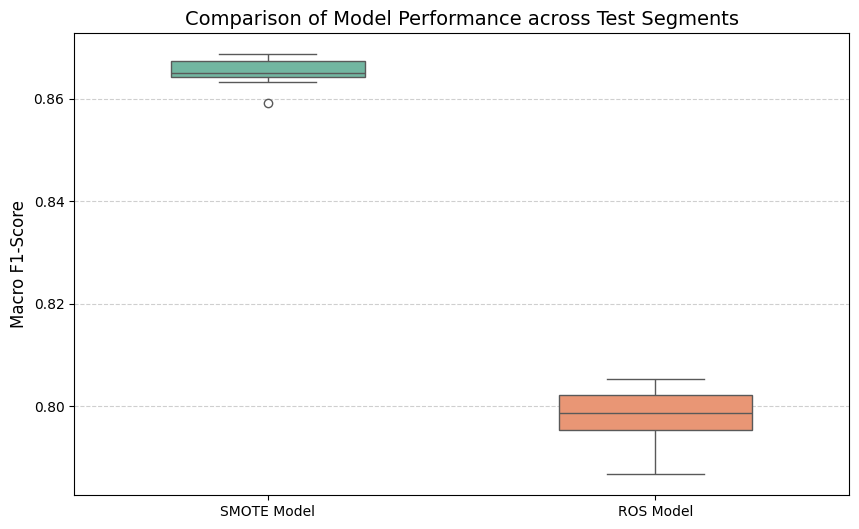

In [4]:
# --- 1. Clean Evaluation Function (Sliding Window) ---
def evaluate_model_on_chunks(model_path, X_data, y_data, n_chunks=10, seq_len=5): 
    print(f"🔄 Loading model for evaluation: {model_path}")
    m = SleepNetSeq().to(device) 
    m.load_state_dict(torch.load(model_path, map_location=device))
    m.eval()
    
    chunk_size = len(X_data) // n_chunks
    chunk_scores = []
    
    # Import f1_score if not already imported at the top of the notebook
    from sklearn.metrics import f1_score 
    
    with torch.no_grad():
        for i in range(n_chunks):
            start = i * chunk_size
            end = (i + 1) * chunk_size
            
            X_chunk = X_data[start:end]
            y_chunk = y_data[start:end]
            
            preds, labels = [], []
            for j in range(len(X_chunk) - seq_len + 1):
                # If data is Numpy, convert to Tensor here
                if isinstance(X_chunk, np.ndarray):
                    window = torch.from_numpy(X_chunk[j:j+seq_len]).float().unsqueeze(0).to(device)
                else:
                    window = X_chunk[j:j+seq_len].clone().detach().float().unsqueeze(0).to(device)
                
                output = m(window)
                _, p = torch.max(output, 1)
                preds.append(p.item())
                
                # Handle the label
                label = y_chunk[j+seq_len-1]
                labels.append(label.item() if torch.is_tensor(label) else label)
            
            score = f1_score(labels, preds, average='macro')
            chunk_scores.append(score)
            print(f"   ✅ Chunk {i+1}/{n_chunks}: F1 = {score:.4f}")
            
    return chunk_scores

f1_smote_list = evaluate_model_on_chunks('model_smote.pth', X_val, y_val)
f1_ros_list = evaluate_model_on_chunks('model_ros.pth', X_val, y_val)

# --- 3. Wilcoxon Signed-Rank Test (One-sided favoring ROS) ---
# Testing if ROS is significantly greater than SMOTE
from scipy.stats import wilcoxon # Ensure this is imported
stat, p_val = wilcoxon(f1_ros_list, f1_smote_list, alternative='greater')

# --- 4. Display Final Results ---
print("\n" + "="*40)
print("📊 Statistical Test Results")
print("="*40)
print(f"SMOTE (Mean F1): {np.mean(f1_smote_list):.4f}")
print(f"ROS (Mean F1):   {np.mean(f1_ros_list):.4f}")
print(f"📊 P-Value (in favor of ROS): {p_val:.5f}")

if p_val < 0.05:
    print("\n✅ Conclusion: The difference is statistically significant! ROS outperforms SMOTE.")
else:
    print("\n⚠️ Conclusion: No statistically significant difference.")

# --- 5. Article Visualization (Boxplot) ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
data_to_plot = [f1_smote_list, f1_ros_list]
sns.boxplot(data=data_to_plot, palette="Set2", width=0.5)
plt.xticks([0, 1], ['SMOTE Model', 'ROS Model'])
plt.title('Comparison of Model Performance across Test Segments', fontsize=14)
plt.ylabel('Macro F1-Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add significance marker above the plot if p < 0.05
if p_val < 0.05:
    x1, x2 = 0, 1
    y, h, col = max(max(f1_smote_list), max(f1_ros_list)) + 0.01, 0.005, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "p < 0.05", ha='center', va='bottom', color=col, weight='bold')

plt.show()

✅ Extracted 55301 epochs from the validation set.
📊 Generating Figure 1 (Physiology)...


/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_1566/4051788742.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Pz-Oz (Occipital)', 'Fpz-Cz (Frontal)'])
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_1566/4051788742.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Fpz-Cz (Frontal)', 'Pz-Oz (Occipital)'])
/var/folders/db/xl8268ms1js3ff3nv7003flh0000gn/T/ipykernel_1566/4051788742.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['REM', 'N3'])


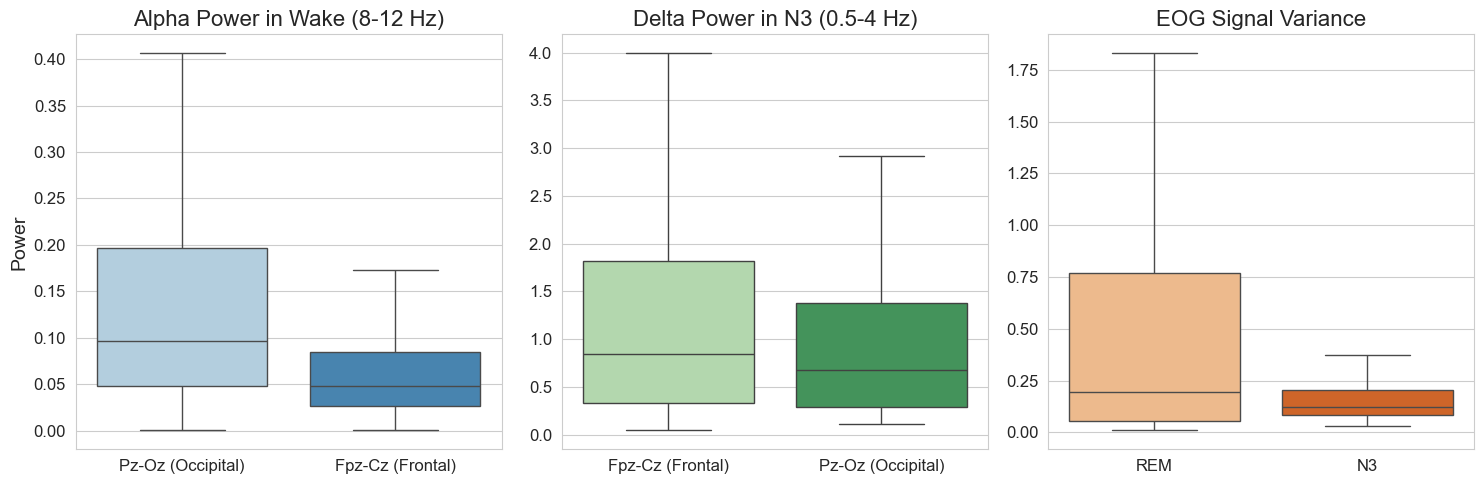

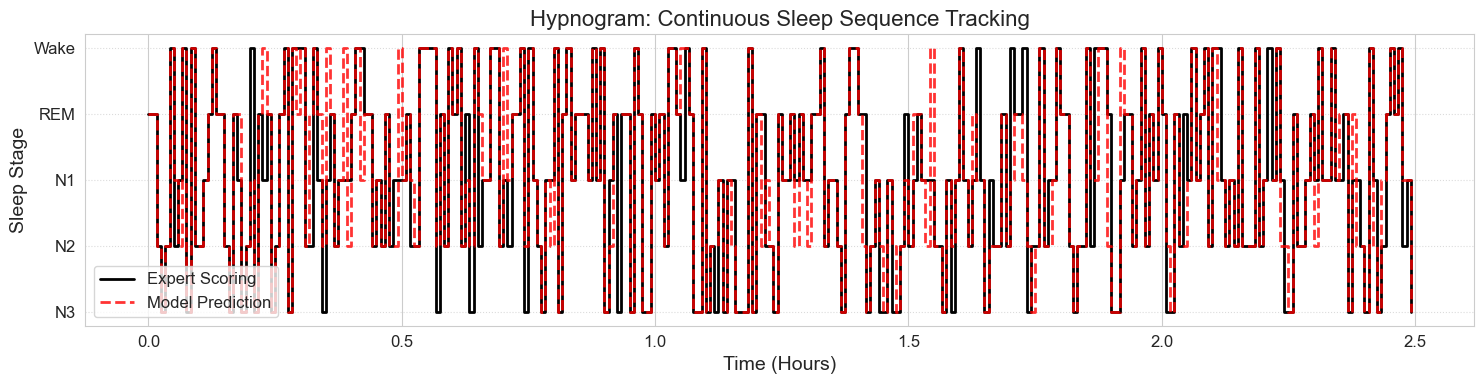

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from scipy.signal import welch
import scipy.stats as stats

# ==========================================
# 0. General Plotting Settings
# ==========================================
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16})
sns.set_style("whitegrid")
sleep_stages = ['W', 'N1', 'N2', 'N3', 'REM']
SAMPLING_RATE = 100  # 3000 samples in 30 seconds = 100Hz

# ==========================================
# 1. Extracting True y_true and y_pred from the Model (ROS)
# ==========================================
model_ros = SleepNetSeq().to(device)
model_ros.load_state_dict(torch.load('model_ros.pth', map_location=device))
model_ros.eval()

y_true_real = []
y_pred_real = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_ros(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true_real.extend(labels.cpu().numpy())
        y_pred_real.extend(preds.cpu().numpy())

y_true_real = np.array(y_true_real)
y_pred_real = np.array(y_pred_real)
print(f"✅ Extracted {len(y_true_real)} epochs from the validation set.")

# ==========================================
# Figure 1: Physiological Validation (from raw X_val data)
# ==========================================
def plot_physiological_validation(X_data, y_data):
    print("📊 Generating Figure 1 (Physiology)...")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Finding indices by stages (0=W, 3=N3, 4=REM)
    idx_w = np.where(y_data == 0)[0]
    idx_n3 = np.where(y_data == 3)[0]
    idx_rem = np.where(y_data == 4)[0]
    
    # Taking a representative sample (up to 500 epochs to avoid memory overload during frequency calculation)
    idx_w = np.random.choice(idx_w, min(500, len(idx_w)), replace=False)
    idx_n3 = np.random.choice(idx_n3, min(500, len(idx_n3)), replace=False)
    idx_rem = np.random.choice(idx_rem, min(500, len(idx_rem)), replace=False)

    # Helper function to calculate power in a specific frequency band
    def get_band_power(data_indices, channel, fmin, fmax):
        powers = []
        for i in data_indices:
            signal = X_data[i, :, channel]
            freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=256)
            band_power = np.sum(psd[(freqs >= fmin) & (freqs <= fmax)])
            powers.append(band_power)
        return np.array(powers)

    # Assuming channels are: 0=Fpz-Cz, 1=Pz-Oz, 2=EOG
    alpha_fpz = get_band_power(idx_w, 0, 8, 12)
    alpha_pz = get_band_power(idx_w, 1, 8, 12)
    
    delta_fpz = get_band_power(idx_n3, 0, 0.5, 4)
    delta_pz = get_band_power(idx_n3, 1, 0.5, 4)
    
    # EOG variance (Channel 2)
    eog_rem = np.var(X_data[idx_rem, :, 2], axis=1)
    eog_n3 = np.var(X_data[idx_n3, :, 2], axis=1)

    # Subplot A: Alpha
    sns.boxplot(data=[alpha_pz, alpha_fpz], ax=axes[0], palette="Blues", showfliers=False)
    axes[0].set_xticklabels(['Pz-Oz (Occipital)', 'Fpz-Cz (Frontal)'])
    axes[0].set_title('Alpha Power in Wake (8-12 Hz)')
    axes[0].set_ylabel('Power')

    # Subplot B: Delta
    sns.boxplot(data=[delta_fpz, delta_pz], ax=axes[1], palette="Greens", showfliers=False)
    axes[1].set_xticklabels(['Fpz-Cz (Frontal)', 'Pz-Oz (Occipital)'])
    axes[1].set_title('Delta Power in N3 (0.5-4 Hz)')

    # Subplot C: EOG
    sns.boxplot(data=[eog_rem, eog_n3], ax=axes[2], palette="Oranges", showfliers=False)
    axes[2].set_xticklabels(['REM', 'N3'])
    axes[2].set_title('EOG Signal Variance')

    plt.tight_layout()
    plt.savefig('fig1_physiological.pdf', dpi=300)
    plt.show()

# ==========================================
# Figure 5: Hypnogram (First 2.5 hours of the validation set)
# ==========================================
def plot_hypnogram(y_t, y_p, epochs_to_show=300):
    plt.figure(figsize=(15, 4))
    
    y_t_seg = y_t[:epochs_to_show]
    y_p_seg = y_p[:epochs_to_show]
    time_axis = np.arange(epochs_to_show) / 120 # Convert to hours
    
    display_map = {0: 0, 4: -1, 1: -2, 2: -3, 3: -4} 
    true_disp = [display_map[v] for v in y_t_seg]
    pred_disp = [display_map[v] for v in y_p_seg]

    plt.step(time_axis, true_disp, label='Expert Scoring', color='black', linewidth=2, where='post')
    plt.step(time_axis, pred_disp, label='Model Prediction', color='red', linestyle='--', linewidth=2, alpha=0.8, where='post')

    plt.yticks([-4, -3, -2, -1, 0], ['N3', 'N2', 'N1', 'REM', 'Wake'])
    plt.xlabel('Time (Hours)')
    plt.ylabel('Sleep Stage')
    plt.title('Hypnogram: Continuous Sleep Sequence Tracking')
    plt.legend(loc='lower left')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('fig5_hypnogram.pdf', dpi=300)
    plt.show()

# ==========================================
# Execute all functions in sequence
# ==========================================
plot_physiological_validation(X_val, y_val) # Calculates frequencies directly from the real X_val
plot_hypnogram(y_true_real, y_pred_real, epochs_to_show=300) # Plots hypnogram